## Acquire and Prep

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split

import env
import split_scale

from math import sqrt
%matplotlib inline

**SQL query to use for the MVP model**

In [2]:
query = """
SELECT 
bathroomcnt AS bath_count,
bedroomcnt AS bedroom_count,
calculatedfinishedsquarefeet AS sqft,
fips,
taxvaluedollarcnt AS assessed_tax_value,                                                                            
(taxamount / taxvaluedollarcnt) AS tax_rate
FROM properties_2017
JOIN predictions_2017 AS pr USING(`parcelid`)
WHERE (transactiondate >= '2017-05-01' AND transactiondate <= '2017-06-30') AND
propertylandusetypeid = 261;"""

In [3]:
#add get_db_url to wrangle.py
URL = env.get_db_url("zillow")

In [4]:
zillow = pd.read_sql(query, URL)

**Take a peek at the data**

In [5]:
zillow.sample(4)

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate
3344,3.0,5.0,2575.0,6059.0,657151.0,0.010202
6099,2.0,3.0,1080.0,6037.0,286796.0,0.013787
9457,2.0,3.0,1779.0,6037.0,519906.0,0.012015
2030,3.0,3.0,3483.0,6111.0,827618.0,0.011186


**Bring in the fips**

In [6]:
FIPS = pd.read_csv("FIPS.txt", sep="\t")

In [7]:
FIPS

,FIPS,Name,State
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL
...,...,...,...
3227,72151,Yabucoa,PR
3228,72153,Yauco,PR
3229,78010,St. Croix,VI
3230,78020,St. John,VI


In [8]:
zillow = pd.merge(left=zillow, right=FIPS, left_on="fips", right_on="FIPS")

In [9]:
zillow

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate,FIPS,Name,State
0,2.0,3.0,1458.0,6037.0,136104.0,0.017045,6037,Los Angeles,CA
1,1.0,2.0,1421.0,6037.0,35606.0,0.015270,6037,Los Angeles,CA
2,2.0,3.0,1650.0,6037.0,614000.0,0.012497,6037,Los Angeles,CA
3,1.0,2.0,693.0,6037.0,274237.0,0.011915,6037,Los Angeles,CA
4,0.0,0.0,1378.0,6037.0,168828.0,0.012648,6037,Los Angeles,CA
...,...,...,...,...,...,...,...,...,...
15031,2.0,3.0,1575.0,6111.0,506000.0,0.010707,6111,Ventura,CA
15032,2.0,3.0,1645.0,6111.0,230986.0,0.012363,6111,Ventura,CA
15033,2.0,3.0,1308.0,6111.0,255407.0,0.010919,6111,Ventura,CA
15034,2.5,4.0,2314.0,6111.0,485364.0,0.019674,6111,Ventura,CA


In [10]:
zillow.rename(columns = {"Name": "county_name"}, inplace = True)

Check the datatypes and info

In [11]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            15036 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


let's check to see how many zeros are in bed and bath

In [12]:
zillow.bath_count.value_counts()

2.0     6182
3.0     3114
1.0     2652
2.5     1155
4.0      671
3.5      302
1.5      240
5.0      233
4.5      217
6.0      102
5.5       65
0.0       40
7.0       25
6.5       15
8.0       14
7.5        4
9.0        3
11.0       1
10.0       1
Name: bath_count, dtype: int64

In [13]:
zillow.bedroom_count.value_counts()

3.0     6668
4.0     4423
2.0     2350
5.0     1158
6.0      183
1.0      177
0.0       42
7.0       27
12.0       3
9.0        2
11.0       1
10.0       1
8.0        1
Name: bedroom_count, dtype: int64

I'm going to drop the zeros in bed and bath to get my MVP out as fast as possible.

- If thime permits later I might try to replace with mean or mode

In [14]:
zillow.bath_count.replace(0, np.nan, inplace=True)

In [15]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [16]:
zillow.bedroom_count.replace(0, np.nan, inplace=True)

In [17]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         14994 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [18]:
zillow.dropna(inplace=True)

In [19]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14989 non-null float64
bedroom_count         14989 non-null float64
sqft                  14989 non-null float64
fips                  14989 non-null float64
assessed_tax_value    14989 non-null float64
tax_rate              14989 non-null float64
FIPS                  14989 non-null int64
county_name           14989 non-null object
State                 14989 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


## Split the data

In [27]:
def split_my_data(df, train_pct=0.70, seed=123):
    """
    Takes in a dataframe, training pct amount and seed to split the into testing and training df
    seed will default to 123 if not specified
    train_pct defaults to .7 if not specified
    """
    train, test = train_test_split(df, train_size=train_pct, random_state=seed)
    return train, test

In [28]:
train, test = split_my_data(zillow, .7, 123)

In [29]:
train.sample(4)

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate,FIPS,county_name,State
14534,2.0,3.0,1791.0,6111.0,175382.0,0.010688,6111,Ventura,CA
5266,1.0,2.0,936.0,6037.0,629455.0,0.012108,6037,Los Angeles,CA
5704,3.0,3.0,2664.0,6037.0,1502570.0,0.012110,6037,Los Angeles,CA
2660,2.0,3.0,1266.0,6037.0,672060.0,0.012131,6037,Los Angeles,CA


# Data Exploration

## Initial Hypothesis
- $H_0$ - There will be no linear difference in assessed home values based on sqft, n bedrooms, n of baths
- $H_a$ - There will be a significant linear difference in home values based on the sqft, n bedrooms and n of baths

In [46]:
mvp_df = train[["bath_count", "bedroom_count", "sqft", "assessed_tax_value"]]

In [32]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]

In [34]:
y_train = train.assessed_tax_value

In [33]:
X_train.head()

,bath_count,bedroom_count,sqft
12620,2.5,3.0,1890.0
12666,2.5,4.0,2045.0
2345,2.0,4.0,2250.0
12384,3.0,3.0,1643.0
12603,2.0,4.0,1599.0


In [35]:
y_train.head()

12620    576038.0
12666    557045.0
2345     284163.0
12384    572000.0
12603    350939.0
Name: assessed_tax_value, dtype: float64

In [31]:
alpha = .05

In [47]:
mvp_df.corr()

,bath_count,bedroom_count,sqft,assessed_tax_value
bath_count,1.000000,0.642765,0.858048,0.528742
bedroom_count,0.642765,1.000000,0.631470,0.276186
sqft,0.858048,0.631470,1.000000,0.604807
assessed_tax_value,0.528742,0.276186,0.604807,1.000000


In [44]:
def plot_variable_pairs(dataframe):
    """This function returns a pairplot to help explore relationships"""
    return sns.pairplot(dataframe, kind="reg")

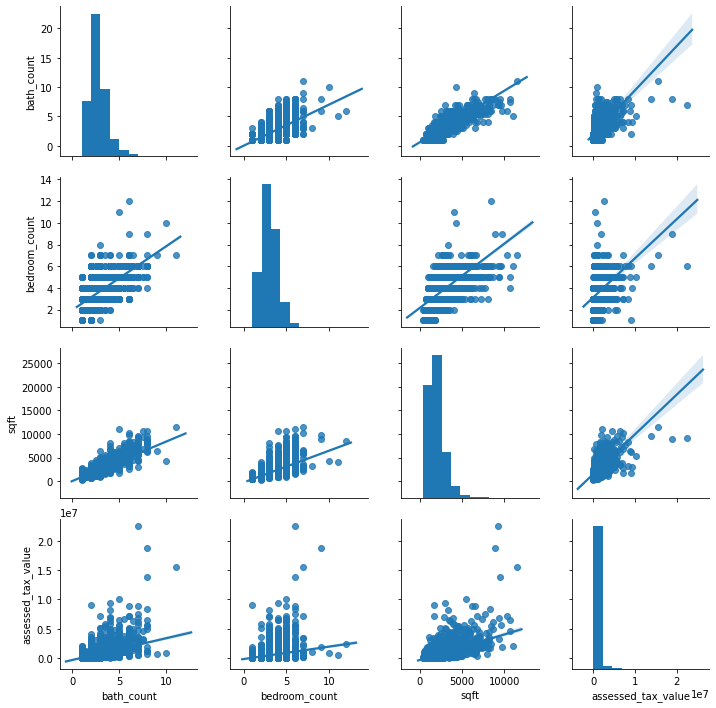

In [48]:
plot_variable_pairs(mvp_df)

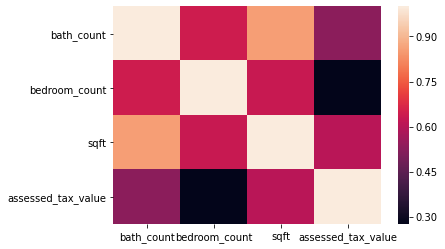

In [51]:
 sns.heatmap(mvp_df.corr())

In [59]:
r_bath, p_bath = stats.pearsonr(mvp_df.bath_count, mvp_df.assessed_tax_value)

In [71]:
print(p_bath)

5.153704730608228e-183


In [70]:
bedroom_count, p_bedroom_count = stats.pearsonr(mvp_df.bedroom_count, mvp_df.assessed_tax_value)

In [72]:
print(p_bedroom_count)

5.153704730608228e-183


In [67]:
r_sqft, p_sqft = stats.pearsonr(mvp_df.sqft, mvp_df.assessed_tax_value)

In [73]:
print(p_sqft)

0.0


In [69]:
if p_bath < alpha and p_bedroom_count < alpha and p_sqft < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Takeaways on exploration 
- house sqft plays the biggest role in assessed tax value
- bedroom counts and bathroom counts are about the same when it comes to driving assessed tax value

# Modeling
- Establish baseline using the mean assessed_tax_value
- create an OLS model and compare to baseline

In [74]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]
y_train = train.assessed_tax_value

In [78]:
X_train.head()

,bath_count,bedroom_count,sqft
12620,2.5,3.0,1890.0
12666,2.5,4.0,2045.0
2345,2.0,4.0,2250.0
12384,3.0,3.0,1643.0
12603,2.0,4.0,1599.0


In [80]:
y_train.head()

12620    576038.0
12666    557045.0
2345     284163.0
12384    572000.0
12603    350939.0
Name: assessed_tax_value, dtype: float64

- create a dataframe to hold all predictions for easy comparisions later

In [76]:
predictions = pd.DataFrame({"actual": train.assessed_tax_value})

In [77]:
predictions.head()

,actual
12620,576038.0
12666,557045.0
2345,284163.0
12384,572000.0
12603,350939.0


In [81]:
predictions["baseline"] = y_train.mean()

In [82]:
predictions

,actual,baseline
12620,576038.0,544075.261151
12666,557045.0,544075.261151
2345,284163.0,544075.261151
12384,572000.0,544075.261151
12603,350939.0,544075.261151
...,...,...
5234,533298.0,544075.261151
12284,4336027.0,544075.261151
1352,259655.0,544075.261151
11677,2086601.0,544075.261151
